In [17]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import math


In [18]:
def getCloseDataPandas(ticker, start,end=None):
    #print("ticker: " ,ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    #print("ticker: " ,ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    #plt.figure(figsize=(15,5))
    #plt.plot(-dd, label="DrawDown")
    #plt.legend(fontsize = 16)
    mdd = dd.max()
    
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 1, 1)
    cumulativeReturn.plot(color="green")
    plt.ylabel("profit", fontsize=20)

    plt.subplot(2, 1, 2)
    plt.plot(-dd, color="red")
    plt.ylabel("draw down", fontsize=20)

    plt.show()

    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 

    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period , weightDf=None):
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
    portfolio = pd.DataFrame()
    totalAsset = 1 
    start = rebalancingDate[0] 
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end] 
        cumReturn = getCumulativeReturn(priceData) 
        weightedCumReturn = weight * cumReturn 
        netCumReturn = totalAsset * weightedCumReturn
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumReturn])
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] 
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 


In [19]:
SPY = getCloseDataPandas("SPY","1994-01","2021-09-30") # 주식
TLT = getCloseDataPandas("TLT","1994-01","2021-09-30") # 예금, 채권
VNQ = getCloseDataPandas("VNQ","1994-01","2021-09-30") # 리츠

In [20]:
closeDataSet = pd.concat([SPY,TLT,VNQ], axis=1)
closeDataSet.columns = ["SPY","TLT","VNQ"]
closeDataSet.dropna(inplace = True)

In [21]:
closeDataSet

,SPY,TLT,VNQ
Date,,,
2004-09-29,111.839996,88.589996,49.849998
2004-09-30,111.760002,88.250000,50.250000
2004-10-01,113.650002,87.449997,51.180000
2004-10-04,113.839996,87.580002,51.400002
2004-10-05,113.900002,87.580002,51.389999
...,...,...,...
2021-09-24,443.910004,146.910004,104.830002
2021-09-27,442.640015,146.369995,103.419998
2021-09-28,433.720001,144.089996,102.720001


In [22]:
rebalancingDate = getRebalancingDate(closeDataSet, "year")
rebalancingDate

DatetimeIndex(['2004-09-30', '2005-09-30', '2006-09-29', '2007-09-28',
               '2008-09-30', '2009-09-30', '2010-09-30', '2011-09-30',
               '2012-09-28', '2013-09-30', '2014-09-30', '2015-09-30',
               '2016-09-30', '2017-09-29', '2018-09-28', '2019-09-30',
               '2020-09-30', '2021-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [23]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet,"year")

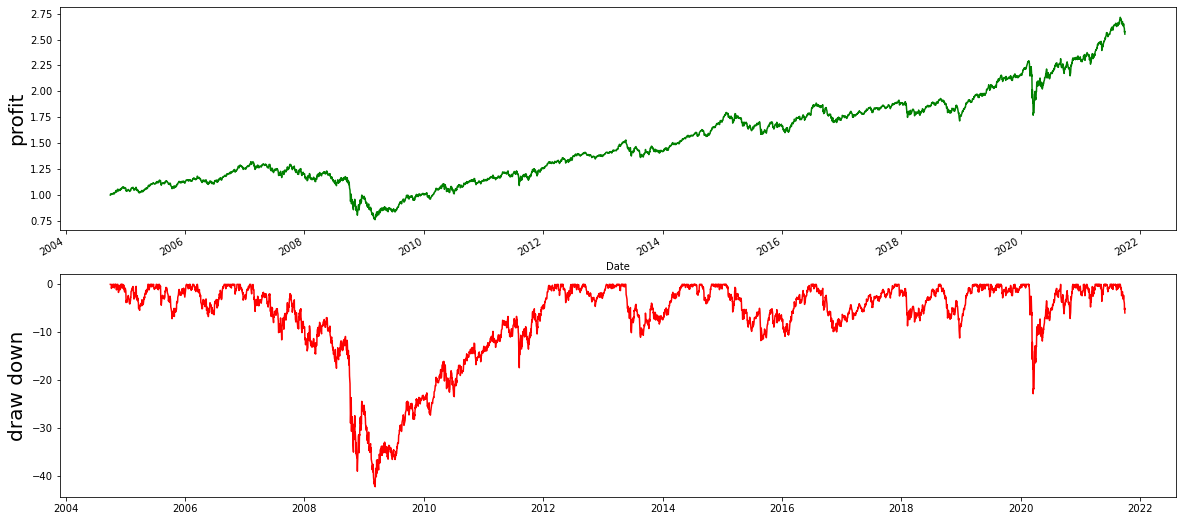

최종 수익률 : 2.5523987063097326
cagr: 1.0567078243378707
mdd: 42.283538126592745


In [24]:
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)